In [1]:
import requests
import pandas as pd
import numpy as np
import pickle
import json
from tqdm import tqdm
from pathlib import Path
import os

import sparkbeyond as sb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, precision_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

import warnings
warnings.filterwarnings('ignore')


from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
import time

#
pull_new_data = False


# TODO 
# - Investigate 2 and 3 week time forecasts
# - Finalise production section to forecast on new data
# - Finalise action layout

In [2]:
# load player data
df = pd.read_csv('00_global_player_database/Historical_complete_player_database.csv', index_col=0)
df.head(4)


,Date,PlayerName,EndofDayPrice,MatchdayScore,MediaScore,MatchdayDividends,MediaDividends
1050,2018-01-01,Jonathan Cafu,0.17,0,0,0.0,0.0
937,2018-01-01,Yann Karamoh,0.17,0,0,0.0,0.0
936,2018-01-01,Sergi Enrich,0.17,0,0,0.0,0.0
935,2018-01-01,Ovie Ejaria,0.17,0,0,0.0,0.0


In [3]:
# Data Pull from FI edge

if pull_new_data == True:
    driver = webdriver.Chrome()
    driver.get('https://members.footballindexedge.com/member/sign_in')

    ## Give time for iframe to load ##
    time.sleep(3)

    username = driver.find_element_by_id("email")
    password = driver.find_element_by_id("password")

    username.clear()
    username.send_keys("")
    password.clear()
    password.send_keys("")

    driver.find_element_by_name("commit").click()

    driver.get("https://www.footballindexedge.com/price-master-q3-2019")
    time.sleep(20)
    # driver.find_element_by_css_selector('div.button.downloadCsv btn-warning downloadButton').click()
    driver.find_element_by_xpath("//*[@id='block-yui_3_17_2_1_1562137191774_3739']/div/div[1]/button[1]").click()
    time.sleep(20)

    # load in downloaded data and merge with existing df
    # os.chdir('/Users/joshualowe/Downloads')
    df_latest = pd.read_csv('/Users/joshualowe/Downloads/Table Data.csv')

    # rename the file ready for the next download
    os.remove('/Users/joshualowe/Downloads/Table Data.csv')

    df_latest.Date = pd.to_datetime(df_latest.Date, format='%d/%m/%Y')
    df_latest.sort_values('Date', inplace=True)
    df_latest.EndofDayPrice = df_latest.EndofDayPrice.str.replace('£', '').astype('float')
    df_latest.MatchdayDividends = df_latest.MatchdayDividends.str.replace('£', '').astype('float')
    df_latest.MediaDividends = df_latest.MediaDividends.str.replace('£', '').astype('float')
    df_latest.fillna(0, inplace=True)

    display(df_latest.tail(4))


    df_latest = df_latest[df_latest['Date'] > df['Date'].max()]
    # merge the two df's
    df = pd.concat((df,df_latest), axis=0)
    df.Date = pd.to_datetime(df.Date)
    df = df.drop_duplicates(keep='first')

    # save the df
    df.to_csv('00_global_player_database/Historical_complete_player_database.csv')
    
df.tail(4)

,Date,PlayerName,EndofDayPrice,MatchdayScore,MediaScore,MatchdayDividends,MediaDividends
2097,2019-09-30,Mario Gaspar,0.23,0,0,0.0,0.0
2096,2019-09-30,Wilfried Bony,0.23,0,0,0.0,0.0
2094,2019-09-30,Federico Pelle,0.23,0,0,0.0,0.0
0,2019-09-30,Neymar,7.58,0,130,0.0,0.0


In [4]:
# load player meta data
df_meta = pd.read_csv('00_global_player_database/player_meta_data.csv')
df_meta.columns = df_meta.columns.str.lower()
df_meta = df_meta[['playername', 'club', 'position', 'positiontype', 'dob', 'age', 'ipoprice']]
df_meta.columns.name = 0 # tip from Dan 
df_meta.head(4)


,playername,club,position,positiontype,dob,age,ipoprice
0,Paul Pogba,Man United,Midfield,Central Midfielder,15/03/1993,26,£0.08
1,Neymar,PSG,Forward,Second Striker/ Winger,05/02/1992,27,£0.08
2,Jadon Sancho,Borussia Dortmund,Midfield,Attacking Midfielder/ Winger,25/03/2000,19,£0.10
3,Kylian Mbappé,PSG,Forward,Centre Forward,20/12/1998,20,£0.08


In [5]:
# load player fantasy football data
df_player_ff = pd.read_csv('00_global_player_database/last_season_top_5_league.csv')
df_player_ff_1 = pd.read_csv('00_global_player_database/this_season_top_5_league.csv')
# df_player_ff_1.rename(columns={'event_date':'time'}, inplace=True)
df_player_ff = pd.concat((df_player_ff, df_player_ff_1), axis=0).reset_index(drop=True)

df_player_ff.columns = df_player_ff.columns.str.lower()
df_player_ff.time = pd.to_datetime(df_player_ff.time).dt.date
# some missing game dates so use the updateAt col
df_player_ff.updateAt = pd.to_datetime(df_player_ff.updateat, unit='s').dt.date
df_player_ff.time = np.where(df_player_ff.time.isna(), df_player_ff.updateAt, df_player_ff.time)

df_player_ff.rename(columns={'player_name':'playername_2', 'time':'date'}, inplace=True)

# split out 2
def split_2_cols(_df_,source_col, name_1, name_2):
    new = _df_[source_col].str.split(',',n = 1, expand = True)
    _df_[name_1], _df_[name_2] = new[0], new[1]
    _df_[name_1], _df_[name_2] = _df_[name_1].map(lambda x: ''.join([i for i in x if i.isdigit()])), _df_[name_2].map(lambda x: ''.join([i for i in x if i.isdigit()]))
    return _df_.drop(columns=[source_col])
    
# split out 3
def split_3_cols(_df_,source_col, name_1, name_2, name_3):
    new = _df_[source_col].str.split(',',n = 1, expand = True)
    new_ = new[1].str.split(',',n = 1, expand = True)
    _df_[name_1], _df_[name_2], _df_[name_3] = new[0], new_[0], new_[1]
    _df_[name_1], _df_[name_2], _df_[name_3] = _df_[name_1].map(lambda x: ''.join([i for i in x if i.isdigit()])), _df_[name_2].map(lambda x: ''.join([i for i in x if i.isdigit()])), _df_[name_3].map(lambda x: ''.join([i for i in x if i.isdigit()]))
    return _df_.drop(columns=[source_col])

# split out 4
def split_5_cols(_df_,source_col, name_1, name_2, name_3, name_4, name_5):
    new = _df_[source_col].str.split(',',n = 1, expand = True)
    new_ = new[1].str.split(',',n = 1, expand = True)
    new__ = new_[1].str.split(',',n = 1, expand = True)
    new___ = new__[1].str.split(',',n = 1, expand = True)
    _df_[name_1], _df_[name_2], _df_[name_3], _df_[name_4], _df_[name_5] = new[0], new_[0], new__[0], new___[0], new___[1]
    _df_[name_1], _df_[name_2] = _df_[name_1].map(lambda x: ''.join([i for i in x if i.isdigit()])), _df_[name_2].map(lambda x: ''.join([i for i in x if i.isdigit()]))
    _df_[name_3], _df_[name_4] = _df_[name_3].map(lambda x: ''.join([i for i in x if i.isdigit()])), _df_[name_4].map(lambda x: ''.join([i for i in x if i.isdigit()]))
    _df_[name_5] = _df_[name_5].map(lambda x: ''.join([i for i in x if i.isdigit()]))
    return _df_.drop(columns=[source_col])

# split out cards
df_player_ff = split_2_cols(df_player_ff,'cards','yellow_card','red_card')
# split out dribbles
df_player_ff = split_3_cols(df_player_ff,'dribbles','dribble_attempts','dribble_success','dribble_past')
# split out duels
df_player_ff = split_2_cols(df_player_ff,'duels','duels_total','duels_won')
# split out fouls
df_player_ff = split_2_cols(df_player_ff,'fouls','fouls_drawn','fouls_commited')
# split out goals
df_player_ff = split_3_cols(df_player_ff,'goals','goals_total','goals_conceded','goal_assists')
# split out passes
df_player_ff = split_3_cols(df_player_ff,'passes','passes_total','passes_key','passes_accuracy')
# split out goals
df_player_ff = split_5_cols(df_player_ff,'penalty','penalty_won','penalty_commited','penalty_score', 'penalty_miss','penalty_saved')
# split out shots
df_player_ff = split_2_cols(df_player_ff,'shots','shots_total','shots_on_target')
# split out tackles
df_player_ff = split_3_cols(df_player_ff,'tackles','tackles_total','tackles_blocks','tackles_interceptions')

df_player_ff.drop(columns=['updateat','fixture_id','team_id','player_id','event_id'], inplace=True)
# subset as the data is too sparse!
df_player_ff = df_player_ff[['playername_2','date','rating','red_card','goals_total','goals_conceded','goal_assists']]
df_player_ff.head(4)

,playername_2,date,rating,red_card,goals_total,goals_conceded,goal_assists
0,Jordan Pickford,2019-01-01,6.7,0,0,1,0
1,Jonjoe Kenny,2019-01-01,6.7,0,0,0,0
2,Michael Keane,2019-01-01,6.2,0,0,0,0
3,Kurt Zouma,2019-01-01,6.9,0,0,0,0


In [6]:
# # load Fixture Difficulty Rating
# df_FDR = pd.read_csv('00_global_player_database/FDR.csv')
# df_FDR.columns = df_FDR.columns.str.lower()
# df_FDR.rename(columns={'teamname':'club', 'kickoff_time':'date'}, inplace=True)
# df_FDR.date = pd.to_datetime(df_FDR.date).dt.date

# df_FDR.head(4)

# TS_FDR   = sb.TimeWindowDefinition(date_col='date', window=28, unit='Days', key_col='club', offset=0,include_until=True,natural_modality='Multiple')

# timeseries_data_FDR = df_FDR
# timeseries_data_FDR.columns.name = 0
# timeseries_context_FDR = sb.Contexts.TimeSeriesMap(data=timeseries_data_FDR,
#                                                time_column = 'date', name = 'Fixture_difficulty_rating', key_column='club') 

# TS_FDR  timeseries_context_FDR



In [7]:
# Fixture Difficulty Rating
df_FDR = []

for filename in Path('00_global_player_database/FDR/').glob('**/*.csv'):
    df_FDR.append(pd.read_csv(filename))

df_FDR = pd.concat(df_FDR).reset_index(drop=True)
df_FDR.rename(columns={'time':'date','team':'club'}, inplace=True)
df_FDR['date'] = pd.to_datetime(df_FDR['date'])#.dt.date


teams_list = []
for team_ in df_FDR.club.unique().tolist():
    teams_list.append(df_FDR[df_FDR.club == team_].resample('1D', on='date').first().fillna(method='ffill'))

df_FDR = pd.concat(teams_list)[['club', 'fiveFixtures']].reset_index(drop=False)
df_FDR['date'] = pd.to_datetime(df_FDR['date']).dt.date
df_FDR.sort_values(by='date', inplace=True)
df_FDR.head()

,date,club,fiveFixtures
651,2018-08-10,Marseille,"[nan, nan, 1.0, 2.0, 4.0]"
24052,2018-08-10,Manchester United,"[nan, nan, 3.0, 2.0, 5.0]"
7732,2018-08-10,Toulouse,"[nan, nan, 5.0, 4.0, 2.0]"
30689,2018-08-10,Leicester,"[nan, nan, 2.0, 2.0, 1.0]"
1303,2018-08-11,Dijon,"[nan, nan, 3.0, 3.0, 4.0]"


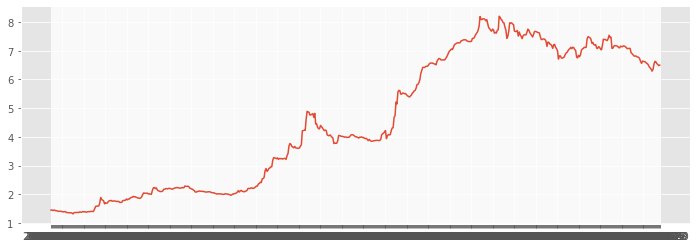

In [8]:
# visualise a single player
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12,4
plt.plot(df[df.PlayerName == 'Paul Pogba']['Date'],df[df.PlayerName == 'Paul Pogba']['EndofDayPrice'])
plt.show()

In [9]:
# create the target column for different time intervals
players = df.PlayerName.unique().tolist()
df_final = []

for p in players:
    tmp = df[df.PlayerName == p]
    tmp.reset_index(inplace=True, drop=True)
    tmp.sort_values('Date', inplace=True)

    days = [7,14,21,28]

    for d in days:
        # calc the price delta for the given time frame
        tmp['Target_'+str(d)+'d'] = tmp['EndofDayPrice'].shift(-d)
        tmp['Target_'+str(d)+'d'] = tmp['Target_'+str(d)+'d'] - tmp['EndofDayPrice']
        # calculate the dividend for said period
        tmp['Dividend_rolling_sum_'+str(d)+'d'] = (tmp['MatchdayDividends'].rolling(d).sum() + tmp['MediaDividends'].rolling(d).sum()).shift(-d)
        # sum the dividend and price delta
        tmp['Target_'+str(d)+'d'] =  tmp['Target_'+str(d)+'d'] + tmp['Dividend_rolling_sum_'+str(d)+'d']
        # calcuate as a % increase
        tmp['Target_'+str(d)+'d'] = ((100/tmp['EndofDayPrice']) * tmp['Target_'+str(d)+'d'] ) - 2
        
        # clip to +- 50 to help with target normalisation
        tmp['Target_'+str(d)+'d'] = tmp['Target_'+str(d)+'d'].clip(-50, 50)

    df_final.append(tmp)
    
# alternative with no loops
# master['RN'] = master.groupby('').cumcount() + 1
# master['RN_2'] = master.RN + 2
# master['RN_9'] = master.RN + 9
# then merge on group and rn & rn_2, or rn & rn_9 respectively

df_final = pd.concat(df_final, axis=0)

df_final = df_final.merge(df_meta[['playername', 'club']], left_on='PlayerName', right_on='playername', how='left')
# df_final.drop(columns={'playername_2', 'club'}, inplace=True)
# create a duplicate id for FF match
df_final['playername_2'] = df_final['PlayerName'] 
df_final.tail(2)

,Date,PlayerName,EndofDayPrice,MatchdayScore,MediaScore,MatchdayDividends,MediaDividends,Target_7d,Dividend_rolling_sum_7d,Target_14d,Dividend_rolling_sum_14d,Target_21d,Dividend_rolling_sum_21d,Target_28d,Dividend_rolling_sum_28d,playername,club,playername_2
1661577,2019-09-29,Marvin Friedrich,0.71,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marvin Friedrich
1661578,2019-09-30,Marvin Friedrich,0.71,0,0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Marvin Friedrich


In [2]:
#Credentials 
server_url_    = ''
api_token     = ''
client = sb.SparkBeyondClient(server_url=server_url_, api_key=api_token)

In [ ]:
d = 28
target = 'Target_'+str(d)+'d'

# drop players that have not played this year
players_to_drop_not_played = set(df_final['playername_2'].unique().tolist()).difference(df_player_ff['playername_2'].unique().tolist())
df_final = df_final[~df_final.isin(players_to_drop_not_played)]

data_run = df_final[['Date', 'PlayerName', 'playername_2', 'club','EndofDayPrice', 'MatchdayScore', 'MediaScore',
                     'MatchdayDividends', 'MediaDividends', target]]
data_run.dropna(subset=[target],inplace=True)

# Add in technical indicators
def add_technicals(data_, string):
    data_['ewm_8']  = data_[string].ewm(span=8).mean()
    data_['ewm_16'] = data_[string].ewm(span=16).mean()
    data_['ewm_32'] = data_[string].ewm(span=32).mean()
    data_['ewm_64'] = data_[string].ewm(span=64).mean()
    data_['ewmc_8_32'] = data_['ewm_8'] - data_['ewm_32']
    data_['ewmc_16_64'] = data_['ewm_16'] - data_['ewm_64']
    return data_['ewm_8'],data_['ewm_16'],data_['ewm_32'],data_['ewm_64'],data_['ewmc_8_32'],data_['ewmc_16_64']

data_run['ewm_8'],data_run['ewm_16'],data_run['ewm_32'],data_run['ewm_64'],data_run['ewmc_8_32'],data_run['ewmc_16_64'] = add_technicals(data_run, 'EndofDayPrice')

# subset on time 
data_run =  data_run[data_run.Date > '2019-01-01']

# players_to_drop = data_run.groupby('PlayerName')[target].agg('median').to_frame().reset_index()
# players_to_drop = players_to_drop[players_to_drop.Target_28d == -2]
# players_to_drop = players_to_drop.sample(frac=0.5,random_state=1).PlayerName.tolist()

# new players to drop 
players_to_drop = ['Thomas Kraft', 'Giovanni Di Lorenzo', 'Nathaniel Chalobah', 'Mehdi Zeffane', 'Lucas Lima', 'Jordi Masip', 'Luka Krajnc', 'Edgar Salli', 'Josh Murphy', 'Oliver Baumann', 'Luca Zidane', 'Bruma', 'Leonardo Bittencourt', 'Mohamed Elyounoussi', 'Jazz Richards', 'Adam Smith', 'Jason Puncheon', 'Kevin Akpoguma', 'Ryad Boudebouz', 'Luuk de Jong', 'Soualiho Meite', 'Anaitz Arbilla', 'Tomas Rincon', 'Albin Ekdal', 'Rene Krhin', 'Romain Saiss', 'Mirko Gori', 'Diego Rico', 'Junior Stanislas', 'Valon Berisha', 'Leandro Chichizola', 'Mark Uth', 'Matteo Darmian', 'Antonino La Gumina', 'Andrei Girotto', 'Louis Beyer', 'Lars Stindl', 'Arturo Vidal', 'Giorgio Chiellini', 'Andrea Poli', 'Paulinho', 'Xabier Etxeita', 'Joselu', 'Sofyan Amrabat', 'Neeskens Kebano', 'Alessandro Florenzi', 'Mitchell Weiser', 'Corentin Jean', 'Axel Disasi', 'Emiliano Velazquez', 'Bakaye Dibassy', 'Manuel Pucciarelli', 'Stefano Okaka', 'Camillo Ciano', 'Terence Kongolo', 'Milan Badelj', 'Phil Jones', 'Danny Latza', 'Omar Colley', 'Charlie Austin', 'Vasco Regini', 'Andreas Cornelius', 'Diego Reyes', 'James Tomkins', 'Dominik Kohr', 'Sergi Palencia', 'Jacopo Dezi', 'Ander Iturraspe', 'Joel Ward', 'Roberto Santamaria', 'Unai Simon', 'Borja Valero', 'Matthew Lowton', 'James McArthur', 'Kenedy', 'Gonzalo Escalante', 'Sergio Busquets', 'Andrew Surman', 'Niko Giesselmann', 'Toni Villa', 'Jordan Lukaku', 'Enzo Crivelli', 'Abdoulaye Ba', 'Marco Capuano', 'Daniel Ginczek', 'Pierrick Valdivia', 'Mikel Vesga', 'Anthony Caci', 'Jorge Pulido', 'Dimitry Bertaud', 'Gaku Shibasaki', 'Rhys Healey', 'Andrea Ranocchia', 'Yannis Salibur', 'Nabil Bentaleb', 'Gary Cahill', 'Yohan Cabaye', 'Victor Wanyama', 'Stefan Ilsanker', 'Neil Etheridge', 'Alexis Blin', 'Yunis Abdelhamid', 'Enzo Loiodice', 'Mubarak Wakaso', 'Francesco Zampano', 'Alireza Jahanbakhsh', 'Mohamed Elneny', 'Jordon Ibe', 'Adrien Tameze', 'Oumar Niasse', 'Bryan Cristante', 'Rolando', 'Yuri Berchiche', 'Maxime Le Marchand', 'Wissam Ben Yedder', 'Aaron Cresswell', 'Florent Hadergjonaj', 'Ramiro Funes Mori', 'Christian Atsu', 'Aritz Elustondo', 'Jordan Ikoko', 'Julian Korb', 'Anthony Knockaert', 'Juan Jesus', 'Yacine Bammou', 'Yevhen Konoplyanka', 'James McCarthy', 'Sebastian Langkamp', 'Lorenzo Pellegrini', 'David Ferreiro', 'Renaud Cohade', 'William Vainqueur', 'Marcel Schmelzer', 'Luca Antonelli', 'Karim Rekik', 'Adnan Januzaj', 'Moussa Sylla', 'Lluis Sastre', 'Rolando Mandragora', 'Benjamin Bourigeaud', 'Umut Bozok', 'Thilo Kehrer', 'Marc-Oliver Kempf', 'Scott Dann', 'Ridle Baku', 'Nolan Roux', 'Thomas Vermaelen', 'Clement Depres', 'Sokratis', 'Kamil Glik', 'Marc-Aurele Caillard', 'Roque Mesa', 'Rodrigo Ely', 'Alfredo Morales', 'Manu Trigueros', 'Anthony Modeste', 'Arnaud Souquet', 'Ezequiel Garay', 'David Abraham', 'Cristian Molinaro', 'Diego Costa', 'Federico Ceccherini', 'Charlie Daniels', 'Jack Cork', 'Lukas Lerager', 'Alexandru Maxim', 'Moussa Sissoko', 'Stefan Bell', 'Yoshinori Muto', 'Jemerson', 'Timo Baumgartl', 'Stefan Posch', 'Mathieu Gorgelin', "Cheikh N'Doye", 'Ashley Young', 'Luiz Gustavo', 'Riccardo Gagliolo', 'Emil Krafth', 'Bruno Martella', 'Afriyie Acquah', 'Radamel Falcao', 'Denis Vavro', 'Maya Yoshida', 'Genki Haraguchi', 'Federico Fazio', 'Johannes Eggestein', 'Quentin Cornette', 'Sada Thioub', 'Amadou Diawara', 'Federico Palacios', 'Wesley Hoedt', 'Jordan Veretout', 'Kevin-Prince Boateng', 'Adil Rami', 'Bas Dost', 'Lucas Deaux', 'Nathaniel Mendez-Laing', 'Daniel Didavi', 'Mamadou Sakho', 'Guido Guerrieri', 'Khouma Babacar', 'Roberto Rosales', 'Ragnar Klavan', 'Robin Koch', 'Jean Zimmer', 'Javi Guerra', 'Diego Benaglio', 'Christian Benteke', 'Ander Capa', 'Alexander Hack', 'Hassane Kamara', 'Khaled Adenon', 'Kenneth Zohore', 'Georg Margreitter', 'Ximo Navarro', 'Theo Valls', 'Pedro Obiang', 'Chadrac Akolo', 'Hamza Mendyl', 'Florian Lejeune', 'Willy Caballero', 'Bernardo Espinosa', 'Hamza Choudhury', 'Oscar Trejo', 'Jonjoe Kenny', 'Miguel Trauco', 'Marco Terrazzino', 'Jose Pozo', 'John Guidetti', 'Angelo Ogbonna', 'Leighton Baines', 'David Costas', 'Michael Rensing', 'Vitor Hugo', 'Shinji Okazaki', 'Isaac Mbenza', 'Craig Cathcart', 'Marcello Trotta', 'Mats Hummels', 'Jeffrey Gouweleeuw', 'Ken Sema', 'Kiko Olivas', 'Nacho Vidal', 'Pirmin Schwegler', 'Ben Davies', 'Bram Nuytinck', 'Robert Bauer', 'Alexander Esswein', 'Matteo Brighi', 'Pione Sisto', 'Islam Slimani', 'Gerard Moreno', 'Mattia Destro', 'Jonathan Biabiany', 'Daniel Bessa', 'Leonardo Capezzi', 'Mehdi Abeid', 'Pedro Bigas', 'Kevin Strootman', 'David Zurutuza', 'Arturo Calabresi', 'Kevin Kampl', 'Giuseppe Pezzella', 'Adama Mbengue', 'Romain Amalfitano', 'Tom Cairney', 'William Troost-Ekong', 'Diego Llorente', 'Matthias Zimmermann', 'Patrick Herrmann', 'Joel Campbell', 'Aboubakar Kamara', 'Emmanuel Badu', 'Quincy Promes', 'Lucas Alario', 'Gonzalo Castro', 'Javier Hernández', 'Marvin Martin', 'Luca Rigoni', 'Alfred Duncan', 'Samuel Grandsir', 'Stuart Armstrong', 'Tim Leibold', 'David Luiz', 'Anthony Limbombe', 'Christian Mathenia', 'Alfred Gomis', 'Abdoulaye Bamba', 'Alexandre Mendy', 'Wu Lei', 'Holger Badstuber', 'Bongani Zungu', 'Olivier Boscagli', 'Papy Djilobodji', 'Francisco Sierralta', 'Lorenzo De Silvestri', 'Laurent Koscielny', 'Jean-Victor Makengo', 'Jeremy Gelin', 'Kevin Lasagna', 'Matt Targett', 'Domenico Maietta', 'Lucas Leiva', 'Suat Serdar', 'Godfred Donsah', 'Panagiotis Tachtsidis', "Danilo D'Ambrosio", 'Miguel Veloso', 'Jannik Vestergaard', 'Enrico Valentini', 'Valter Birsa', 'Arthur', 'Oliver Sorg', 'Allan Nyom', "Clinton N'Jie", 'Kevin McDonald', 'Robert Snodgrass', 'Ghislain Konan', 'Pablo Insua', 'Pietro Terracciano', 'Joe Bryan', 'Elias Kachunga', 'Omar Mascarell', 'Konstantinos Stafylidis', 'Kenny Tete', 'Pablo Zabaleta', 'Luiz Felipe', 'Romain Thomas', 'Dante', 'Nayef Aguerd', 'Mikael Ishak', 'Vittorio Parigini', 'Kevin Vogt', 'Jaume Costa', 'Paolo Ghiglione', 'Borna Sosa', 'Andrea Barzagli', 'Danny Williams', 'Takashi Usami', 'Kevin Zohi', 'Bobby Reid', 'Ludovic Baal', 'Christopher Schindler', 'Diego Falcinelli', 'Callum Paterson', 'Pablo Martinez', 'Mauro Icardi', 'Juanfran', 'Jordan Amavi', 'Sead Kolašinac', 'Damian Musto', 'Riccardo Saponara', 'Adam Lallana', 'Guido Carrillo', 'Ruben Alcaraz', 'Fraser Forster', 'Marko Rog', 'Andrea Rispoli', 'Francesco Vicari', 'Thiago Maia', 'Roberto Soriano', 'Eric Dier', 'Nacho Martinez', 'Isaac Hayden', 'Luciano Vietto', 'Abdelhamid Sabiri', 'Xeka', 'Lars Bender', 'Federico Mattiello']

# old players to drop
# players_to_drop = ['Francesco Bardi', 'Francesco Rossi', 'Wes Morgan', 'Pablo Martinez', 'Pierre Lees-Melou', 'Paolo Hurtado', 'Joel Pereira', 'Joe Bryan', 'Fraser Forster', 'Cristian Zapata', 'Alfa Semedo', 'Danilo Barbosa', 'Anthony Limbombe', 'Sergio Oliveira', 'Jung Woo-young', 'Juan Iturbe', 'Michal Krmencik', 'Ben Davies', 'Ahmed Hegazi', 'Laurent Koscielny', 'Torles Knoll', 'Yoel Armougom', 'Jeison Murillo', 'Godfred Donsah', 'Nicolas Benezet', 'Qara Qarayev', 'Bruno Gaspar', 'Suk Hyun-Jun', 'Victor Ruiz', 'Callum Paterson', 'Salem Al Dawsari', 'Davide Santon', 'Teofilo Gutierrez', 'Antonio Rukavina', 'Alex Moreno', 'Ahmed Khalil', 'Ivan Cavaleiro', 'Lorenzo Polvani', 'Gabriele Angella', 'Konstantinos Stafylidis', 'Majid Hosseini', 'Gaku Shibasaki', 'Sverrir Ingason', 'Milan Rodic', 'Damien Le Tallec', 'Ganso', 'Pascal Stenzel', 'Nikita Chernov', 'Marek Suchy', 'Carlos Sanchez', 'Bingourou Kamara', 'Junior Sambia', 'Raul Albiol', 'German Pezzella', 'Elseid Hysaj', 'Timo Baumgartl', 'Ibrahima Cisse', 'Nicolas Lodeiro', 'Hussain Al-Mogahwi', 'Cyrus Christie', 'Bobby Wood', 'Christian Fuchs', 'Diego Rico', 'Mikael Lustig', 'Ko Yo-Han', 'Alhaji Gero', 'Nuri Sahin', 'Mark Milligan', 'Robin Koch', 'Robbie Brady', 'Mathieu Peybernes', 'Antonio Di Gaudio', 'Ali Albulayhi', 'Michael Esser', 'Anderson Santamaria', 'Zlatko Junuzovic', 'Francisco Calvo', 'Andrej Galabinov', 'Saif-Eddine Khaoui', 'Michael Luftner', 'Gotoku Sakai', 'Ghislain Konan', 'Radja Nainggolan', 'Ivan Marcano', 'Johan Venegas', 'Mirko Gori', 'Maxime Gonalons', 'Guillermo Ochoa', 'Yuto Nagatomo', 'Oribe Peralta', 'Federico Ceccherini', 'Valentin Vada', 'Mahmoud Abdel Aziz', 'Lassana Coulibaly', 'Ivan Balliu', 'Remi Walter', 'Carlos Caceda', 'Taulant Xhaka', 'Rolando Mandragora', 'Stephen Ward', 'Giovanni Di Lorenzo', 'Joel Obi', 'Yasser Al-Mosailem', 'Gianmarco Ferrari', "Clinton N'Jie", 'Luca Zuffi', 'Joel Untersee', 'Takashi Inui', 'Mathieu Gorgelin', 'Soslan Dzhanaev', 'Almog Cohen', 'Omar Mascarell', 'Martin Linnes', 'Ronny Rodelin', 'Lucas Lima', 'Nestor Araujo', 'Paul Baysse', 'Alessandro Deiola', 'Daler Kuzyaev', 'Hamdi Nagguez', 'Jonathan Rivierez', 'Jimmy Durmaz', 'Yannis Salibur', 'Felipe Dal Bello', 'Michael Gregoritsch', 'Prejuce Nakoulma', 'Mahmoud Dahoud', 'Alberto Guitian', 'Stefan Posch', 'Jon Dagur Thorsteinsson', 'Ritsu Doan', 'Vittorio Parigini', 'Mathieu Valbuena', 'Bruno Peres', 'Yunis Abdelhamid', 'Diego Contento', 'Vitolo', 'Adrien Silva', 'Jakub Jankto', 'Rafael Marquez', 'Haji Wright', 'Leon Balogun', 'Vincent Aboubakar', 'Tommaso Berni', 'Arlind Ajeti', 'Thomas Fontaine', 'Olafur Skulason', 'David Costas', 'Daniel Ginczek', 'Abdoulaye Bamba', 'Lasse Schone', 'Claudio Marchisio', 'Yuya Kubo', 'Florent Hadergjonaj', 'Ryad Boudebouz', 'Antonito', 'Theo Valls', 'Giulio Donati', 'Luca Matarese', 'Ronald Matarrita', 'Alberto de la Bella', 'Mathew Leckie', 'Miguel Trauco', 'Petr Cech', 'Antonino La Gumina', 'Hotaru Yamaguchi', 'Yun Young-sun', 'Bongani Zungu', 'Christian Cueva', 'Facundo Roncaglia', 'Baptiste Guillaume', 'Panagiotis Tachtsidis', 'Aly Ndom', 'Jose Pozo', 'Tim Kleindienst', 'Jason Puncheon', 'Alexandre Mendy', 'Gonzalo Escalante', 'Oriol Romeu', 'Nikola Kalinic', 'Kouadio Dabila', 'Andreas Cornelius', 'DeAndre Yedlin', 'Yasir Al Shahrani', 'Jerome Boateng', 'Grady Diangana', 'Dennis Diekmeier', 'Marko Pjaca', 'Leighton Baines', 'Kim Min-woo', 'Vincent Bessat', 'Francesco Vicari', 'Romain Saiss', 'Ante Budimir', 'Chris Philipps', 'Stefano Denswil', 'Alex Alegria', 'Sergio Busquets', 'Gabriel Mercado', 'Mohamed Abdel-Shafy', 'Blas Perez', 'Pontus Jansson', 'Mateusz Klich', 'Mariano', 'Kenny Saief', 'Mikel Agu', 'Leonardo Capezzi', 'Nabil Dirar', 'Johnny Acosta', 'Senad Lulic', 'Pepe Reina', 'Mitchell Langerak', 'Morteza Pouraliganji', 'Sami Ben Amar', 'Marek Hamšík', 'Omid Ebrahimi', 'Anaitz Arbilla', 'Mohamed El-Shenawy', 'Karlo Letica', 'Mohamed Ben Amor', 'Luiz Adriano', 'Daniele Verde', 'Alexander Esswein', 'Hwang Hee-Chan', 'Johannes Eggestein', 'Kevin Wimmer', 'Carlos Clerc', 'Michael Krohn-Dehli', 'David Hancko', 'Etrit Berisha', 'Vedad Ibisevic', 'Davor Lovren', 'Carles Gil', 'Bram Nuytinck', 'Albert Gudmundsson', 'Valentin Rosier', 'Abdulkadir Omur', 'Tana Dominguez', 'Uros Matic', 'Dimitrios Siovas', 'Miranda', 'Jordan Rossiter', 'Paul Lasne', 'Yury Gazinsky', 'Frederik Schram', 'Julian Baumgartlinger', 'Marcin Kaminski', 'Alfredo Talavera', 'Yohan Benalouane', 'Aziz Bouhaddouz', 'Mikael Ishak', 'Aymen Abdennour', 'Aleksandar Jovanovic', 'Roderick Miranda', 'Jaka Bijol', 'Valentin Pimentel', 'Denis Davydov', 'Andrey Lunev', 'Christophe Kerbrat', 'Bruno Ecuele Manga', 'Fabrizio Bagheria', 'Tom Cairney', 'Filip Helander', 'Maycon', 'Matthew Jurman', 'Junior Alonso', 'Abdelhamid Sabiri', 'Moussa Doumbia', 'Ivan Radovanovic', 'Mousa Dembele', 'Greg Cunningham', 'Lee Yong', 'Essam El-Hadary', 'Benjamin Bourigeaud', 'Maxime Dupe', 'Joaquin Fernandez', 'Javier Hernández', 'Joe Ralls', 'Cedric Soares', 'Pierre-Emile Hojbjerg', 'Sergei Chernik', 'Khalid Boutaib', 'Youssef Toutouh', 'Roberto Santamaria', 'Diego Costa', 'Yohan Cabaye', 'Ivan Santini', 'Patrice Evra', 'Ibrahima Mbaye', 'Andre Almeida', 'Marco Sportiello', 'Davide Di Gennaro', 'Manu Garcia', 'Kevin Kampl', 'Simone Zaza', 'Daniele Baselli', 'Gabriel Boschilia', 'Tin Jedvaj', 'Umut Bozok', 'Gil Dias', 'Lars Lukas Mai', 'Juan Quintero', 'Javier Eraso', 'Diego Benaglio', 'Sebastian Langkamp', 'Taylan Duman', 'Aaron Cresswell', 'Ilya Kutepov', 'Juan Lopez', 'Slawomir Peszko', 'Kwadwo Asamoah', 'Alin Tosca', 'Lluis Sastre', 'Arkadiusz Reca', 'Chema Rodriguez', 'Adil Rami', 'Jan Kopic', 'Paulo Oliveira', 'Luka Krajnc', 'Jack Stephens', 'Faouzi Ghoulam', 'Miguel Veloso', 'Oier Olazabal', 'Cameron Carter-Vickers', 'Carlos Vela', 'Olivier Boscagli', 'Andrea Barberis', 'Samuel Perez', 'Xabier Etxeita', 'Gianluigi Buffon', 'Ola Toivonen', 'Christian Mathenia', 'Marvin Zeegelaar', 'Pere Pons', 'Jean-Clair Todibo', 'Adrien Trebel', 'Dario Lezcano', 'Raphael Wolf', 'Hugo Ayala', 'Alessio Da Cruz', 'Gaston Silva', 'Dani Garcia', 'Alexis Blin', 'Martin Campana', 'Hamza Choudhury', 'Nikola Katic', 'Theodor Gebre Selassie', 'Patrick Pemberton', 'Kaylen Hinds', 'Samuel Mraz', 'Jeremy Toljan', 'Jose Leon', 'Lee Seung-Woo', 'Ruben Perez', 'Maxime Poundje', 'Patrick Erras', 'Barry Douglas', 'Leonardo Balerdi', 'Erik Pieters', 'Christian Luyindama', 'Santiago Ascacibar', 'Peter Crouch', 'Thomas Heurtaux', 'Seydou Sy', 'Riccardo Saponara', 'Marko Vesovic', 'Bruno Martella', 'Carlos Salcedo', 'Lucas Biglia', 'Moussa Sow', 'Holmar Eyjolfsson', 'Jeremiah St. Juste', 'Afonso Figueiredo', 'Nils Petersen', 'Alberto Quintero', 'Frank Acheampong', 'Roberto Rosales', 'Jose Mauri', 'Bernard', 'Florian Lejeune', 'Sven Ulreich', 'Vitinho', 'Sergio Gonzalez', 'Xavier Chavalerin', 'Sebastian Larsson', 'Nampalys Mendy', 'Taiseer Al Jassam', 'Luca De La Torre', 'Robin Olsen', 'Joe Bennett', 'Almamy Toure', 'Tomas Pina', 'Robin Bormuth', 'Johann Carrasso', 'Jonas Knudsen', 'Quentin Cornette', 'Marko Dmitrovic', 'Xeka', 'Andrija Zivkovic', 'Corentin Jean', 'Per Skjelbred', 'Eder Balanta', 'Mattia De Sciglio', 'Federico Di Francesco', 'Javi Martinez', 'Borja Garcia', 'Javi Moyano', 'Javier Pastore', 'Filip Bradaric', 'Marwan Mohsen', 'Ricky van Wolfswinkel', 'Loic Damour', 'Dwight Gayle', 'Tom Carroll', 'Fernando Torres', 'Artem Sukhotsky', 'Bryan Cristante', 'Alfred Gomis', 'Bartosz Kapustka', 'Gaston Ramirez', 'David Lopez', 'Felipe Pardo', 'Adam Smith', 'Arnaud Souquet', 'Martin Montoya', 'Oscar de Marcos', 'Matteo Darmian', 'Kim Seung-gyu', 'Yeltsin Tejeda', 'Pejman Montazeri', 'Radamel Falcao', 'Santiago Caseres', 'Mattias Kait', 'Dominic Maroh', 'Georg Margreitter', 'Sebastian Driussi', 'Adam Lallana', 'Giovanni dos Santos', 'Gabriel Paulista', 'Lorenzo Tonelli', 'Frederik Sorensen', 'Alessio Romagnoli', 'Gelson Dala', 'Winston Reid', 'Aissa Mandi', 'Birkir Bjarnason', 'Emil Hallfredsson', 'Filippo Romagna', 'Danny Simpson', 'Keko', 'Yunus Malli', 'Kamil Grosicki', 'Robert Bauer', 'Sebastien Corchia', 'Roque Mesa', 'Odisseas Vlachodimos', 'Naldo', 'Ahmed Musa', 'Alexander Selikhov', 'Thiago Cionek', 'Federico Fazio', 'Carlos Andres Sanchez', 'Matheus Fernandes', 'Oscar Trejo', 'Mbark Boussoufa', 'Ibai Gomez', 'Marc Navarro', 'Gustavo Gomez', 'Ronael Pierre Gabriel', 'Dimitri Petratos', 'Thomas Müller', 'Riccardo Gagliolo', 'Vlad Chiriches', 'Rhys Healey', 'Kike Garcia', 'Thomas Monconduit', 'Patrick Pentz', 'Emmanuel Badu', 'Gervinho', 'Jonas Lossl', 'Pape Cheikh', 'Romain Metanire', 'Ki Sung-yueng', 'Kristoffer Nordfeldt', 'Marc Muniesa', 'Kevin Theophile-Catherine', 'Kenan Karaman', 'Nordin Amrabat', 'Jean Zimmer', 'Badr Banoun', 'Jang Hyun-soo', 'Lukasz Skorupski', 'Marc-Oliver Kempf', 'Stefan Ilsanker', 'Yoshinori Muto', 'Kenneth Zohore', 'Bruno Soriano', 'Jules Iloki', 'Jozabed Sanchez', 'Abdulmalek Al-Khaibri', 'Mario Lemina', 'Pedro Obiang', 'Georgios Siadas', 'Thomas Delaney', 'Jorge Moraes', 'Fede Cartabia', 'Hanno Behrens', 'Jorge Miramon', 'Ander Capa', 'Izet Hajrovic', 'Karim Rekik', 'Rodrigo Battaglia', 'Artur Boruc', 'Manuel Pasqual', 'Mehdi Benatia', 'Joel Robles', 'Alex Rodriguez', 'Yuri Berchiche', 'Carlos Akapo', 'Will Hughes', 'Jurgen Damm', 'Oscar Wendt', 'Jose Calderon', 'Isaac Success', 'Ahmed Gomaa', 'Osama Hawsawi', 'Mamadou Samassa', 'Serdar Gurler', 'Karim Hafez', 'Fagner', 'Scott Sinclair', 'Juanfran', 'Emil Krafth', 'Rogerio', 'Yoann Andreu', 'Ricardo Rodriguez', 'Ali Adnan', 'Raphinha', 'Herve Lybohy', 'Saido Berahino', 'Joselu', 'Josh Onomah', 'Aldo Corzo', 'Vanja Milinkovic-Savic', 'Christian Gunter', 'Aaron Hunt', 'Gerard Moreno', 'Andre Carrillo', 'Thiago Motta', 'Pietro Terracciano', 'Jordan Storey', 'Luis Ovalle', 'Tomi Juric', 'Ari Skulason', 'Dusan Tadic', 'Andreas Granqvist', 'Karl Darlow', 'Jurgen Locadia', 'Rachid Ghezzal', 'Reece Oxford', 'Alex Gallar', 'Loren Moron', 'Ogenyi Onazi', 'Pawel Olkowski', 'Pablo Insua', 'Denis Vavro', 'Bryan Dabo', 'Fahad Al-Muwallad', 
#                    'Pierre Kunde', 'Jordy Clasie', 'Mehdi Torabi', 'Daryl Janmaat', 'Andrea Poli', 'Oliver Sorg', 'Tom Ince', 'Lamine Gassama', 'Karl-Johan Johnsson', 'Francisco Sierralta', 'Igor Smolnikov', 'Timo Letschert', 'Guido Pizarro', 'Simone Scuffet', 'Francis Coquelin', 'Omar Hawsawi', 'Chadrac Akolo', 'Michel Macedo', 'Ondrej Petrak', 'Denis Petric', 'Vitor Hugo', 'Kevin Lasagna', 'William Vainqueur', 'Valon Berisha', 'Emre Colak', 'Fabio Borini', 'Nilson Loyola', 'Enock Mwepu', 'Dedryck Boyata', 'Jackson Irvine', 'Giovanni Moreno', 'Diego Rolan', 'Hal Robson-Kanu', 'Tristan Dingome', 'Alberto Brignoli', 'Valere Germain', 'Ron-Robert Zieler', 'Kim Jin-hyeon', 'Jung Seung-hyun', 'Guido Guerrieri', 'David Luiz', 'Abdullah Al Khaibari', 'Jiri Pavlenka', 'David Ferreiro', 'Hong Chul', 'Alen Halilovic', 'Anuar Mohamed', 'Dante', 'Cedric Bakambu', 'Giannis Anestis', 'Javi Guerra', 'Mauro Icardi', 'Kwon Kyung-won', 'Simone Iacoponi', 'Ashkan Dejagah', 'Jose Corona', 'Andres Iniesta', 'John Guidetti', 'Jordan Ayew', 'Fin Bartels', 'Marc-Aurele Caillard', 'Sergio Leon', 'Federico Fernandez', 'Makoto Hasebe', 'Mapou Yanga-Mbiwa', 'Samuel Tetteh', 'Bruno Cesar', 'Vladimir Stojkovic', 'Enzo Loiodice', 'Celso Borges', 'Amr Warda', 'Benjamin Stambouli', 'Samuel Grandsir', 'Enrico Valentini', 'Morgan Schneiderlin', 'Karim Ansarifard', 'Silvan Widmer', 'Johan Djourou', 'Nicolae Stanciu', 'Franco Di Santo', 'Mattia Perin', 'Ramiro Funes Mori', 'Lee Keun-ho', 'Cristian Ramirez', 'Joao Carvalho', 'Marcello Trotta', 'John Ruddy', 'Mohammad Khanzadeh', 'Bastian Oczipka', 'Clement Depres', 'Tim Cahill', 'Marcus Berg', 'Sime Vrsaljko', 'Miguel Layun', 'Mile Jedinak', 'Guido Carrillo', 'Mauricio Lemos', 'Jonathan Urretaviscaya', 'Francesco Acerbi', 'Marin Pongracic', 'Mohannad Aseri', 'Gonzalo Castro', 'Milan Badelj', 'Jannik Vestergaard', 'Nicolas Cozza', 'Adama Traore', 'Denis Odoi', 'Not Available', 'Leigh Griffiths', 'Giorgio Chiellini', 'Hassane Kamara', 'Emmanuel Besea', 'Joffrey Cuffaut', 'Theo Pellenard', 'Rick Karsdorp', 'Marvin Martin', 'Enzo Crivelli', 'Gabriel Gomez', 'Ricardo Quaresma', 'Michal Marcjanik', 'Alex Telles', 'Ahmed Tagnaouti', 'Bjorn Sigurdarson', 'Patrik Schick', 'Stefan Radu', 'Andrea Beghetto', 'Nicolas Gonzalez', "Danilo D'Ambrosio", 'Ryan Bennett', 'Alessandro Schopf', 'Neeskens Kebano', 'Yacine Bammou', 'Moussa Sissoko', 'Adrian Lopez', 'Rurik Gislason', 'Lee Peltier', 'Nathaniel Chalobah', 'Kamil Jozwiak', 'Cho Hyun-woo', 'Lee Jae-sung', 'Abdoul Camara', 'Martin Olsson', 'Xande Silva', 'Domenico Maietta', 'Palko Dardai', 'Sebastian Coates', 'Ashley Williams', 'Keisuke Honda', 'Danny Latza', 'Lukas Lerager', 'Salvador Ichazo', 'Eric Dier', 'Daniel Opare', 'Cedric Yambere', 'Fredrik Gulbrandsen', 'Milos Jojic', 'Fabian Holland', 'Juan Mata', 'James McCarthy', 'Rafael', 'Arnel Jakupovic', 'Toni Villa', 'Miguel Araujo', 'Otavio', 'Patrick Bamford', 'Rafael Ferreira', 'Pepe', 'Mehdi Zeffane', 'Guillaume Hoarau', 'Hannes Halldorsson', 'Jasmin Kurtic', 'Francesco Zampano', 'Stanislav Lobotka', 'Giacomo Satalino', 'Charles Traore', 'Jacques-Alaixys Romao', 'Loic Badiashile', 'Sergio Alvarez', 'Patrick Twumasi', 'Pedro Aquino', 'Romain Amalfitano', 'Maciej Rybus', 'Santiago Arias', 'Lars Bender', 'Raphael Holzhauser', 'Markus Suttner', 'Rafael Toloi', 'Antonio Barreca', 'Antonio Caracciolo', 'Sam Field', 'Guilherme Arana', 'Ben Gibson', 'Sofiane Feghouli', 'Leo Bonatini', 'Helder Costa', 'Enzo Roco', 'Afriyie Acquah', 'Dimitry Bertaud', 'Alexandre Oukidja', 'Marlon Santos', 'Jeremy Gelin', 'Franco Armani', 'Jordi Amat', 'Emiliano Velazquez', 'Ismael Diaz', 'Victor Moses', 'Benjamin Jeannot', 'Diego Demme', 'Alessandro Florenzi', 'Perparim Hetemaj', 'Leo Baptistao', 'Islam Slimani', 'Ezequiel Ponce', 'Ricardo Avila', 'Scott Malone', 'Havard Nielsen', 'Lars Stindl', 'Tashan Oakley-Boothe', 'Diego Laxalt', 'Davy Klaassen', 'Kevin McDonald', 'Nahuel Guzman', 'Jean Seri', 'Eric Davis', 'Nacho Martinez', 'Yannick Bolasie', 'Luuk de Jong', 'Matej Mitrovic', 'Aritz Elustondo', 'Claudio Yacob', 'Massimo Luongo', 'Lukas Klunter', 'Gideon Jung', 'Sergio Rico', 'Mubarak Wakaso', 'Chechu Dorado', 'Miguel Guerrero', 'Mathias Jorgensen', 'Franck Ribery', 'Cristian Ansaldi', 'Martin Caceres', 'Lorenzo De Silvestri', 'Enrico Brignola', 'Ivan Arboleda', 'Anthony Knockaert', 'Ben Sheaf', 'Sami Khedira', 'Brahim Diaz', 'Rodrigo Ely', 'Francis Uzoho', 'Marco Parolo', 'Danilo Pereira', 'Nicolas Tagliafico', 'Axel Disasi', 'Bartosz Bereszynski', 'Adrian Gonzalez', 'Alex Granell', 'Jake Livermore', 'Andrea Rispoli', 'Mateo Kovacic', 'William Troost-Ekong', 'Lass', 'Stefan Bell', 'Cristiano Lombardi', 'Sead Haksabanovic', 'Landry Dimata', 'Sean Morrison', 'Daniel Colindres', 'Takuma Asano', 'Miguel Borja', 'Ervin Zukanovic', 'Aleksandar Susnjar', 'Soualiho Meite', 'Marcus Bettinelli', 'Luca Rigoni', 'Mansour Al-Harbi', 'Yassine Bounou', 'Tono', 'Edwin Cardona', 'Samuel Saiz', 'Danilo Soddimo', 'Marvin Ducksch', 'Takumi Minamino', 'Kyle Naughton', 'Matthias Ostrzolek', 'Claudio Bravo', 'Alessandro Bastoni', 'Christian Clemens', 'Vladislav Ignatjev', 'Leroy Fer', 'Nathaniel Phillips', 'Robin Hack', 'Anastasios Donis', 'Alfie Mawson', 'Abdoulaye Diallo', 'Miguel Britos', 'Fedor Kudryashov', 'Abdoulaye Toure', 'Pedro Geromel', 'Giovani Lo Celso', 'Marco Fabian', 'John Ogu', 'Javi Garcia', 'Tonny Vilhena', 'Maxim Koval', 'Aleksa Terzic', 'Bruno Martins Indi', 'Marco Sau', 'Rafal Kurzawa', 'Gen Shoji', 'Damian Suarez', 'Kazaiah Sterling', 'Ryan Jack', 'Reza Ghoochannejhad', 'Aly Keita', 'David Junior Hoilett', 'Harry Arter', 'Wallace', 'Ramadan Sobhi', 'Ryan Gauld', 'Sam Clucas', 'Julian Korb', 'Kieran Gibbs', 'Federico Ricca', 'Anderson-Lenda Lucoqui', 'Kyriakos Papadopoulos', 'Birkir Saevarsson', 'Eiji Kawashima', 'Andrew Nabbout', 'Jonny Evans', 'Aziz Behich', 'Raffaele Maiello', 'Herve Bazile', 'Antonio Luna', 'Jorge Pulido', 'Casemiro', 'Konstantinos Galanopoulos', 'Paul-Georges Ntep', 'Sergi Palencia', 'Emiliano Insua', 'Yeray Alvarez', 'Mamadou Thiam', 'Simeon Nwankwo', 'Muhamed Besic', 'Unai Simon', 'Martin Kelly', 'Pablo Piatti', 'Cheikhou Kouyate', 'Slavoljub Srnic', 'Sandro Ramirez', 'James Tomkins', 'Abel Aguilar', 'Kevin Zohi', 'Derlis Gonzalez', 'Yann Karamoh', 'Saidy Janko', 'Shikabala', 'Maxim Lunev', 'Rami Bedoui', 'Aron Gunnarsson', 'Bartosz Salamon', 'Matthew Connolly', 'Jeffrey Gouweleeuw', 'Lukasz Teodorczyk', 'Vedran Corluka', 'Claud Adjapong', 'Lucas Leiva', 'Mohamed Elneny', 'Luke Amos', 'Mirco Antenucci', 'Christophe Jallet', 'Keylor Navas', 'Dominique Heintz', 'Anibal Godoy', 'Felix Wiedwald', 'Salih Ozcan', 'Carlos Bacca', 'Manolo Gabbiadini', 'Duje Cop', 'Kevin Long', 'Andrei Girotto', 'Kortney Hause', 'Sandro Wagner', 'Luciano Vietto', 'Elderson Echiejile', 'Luiz Gustavo', 'Antonio Barragan', 'Lorenzo Lollo', 'Dylan Bronn', 'Abdiel Arroyo', 'Jonathan Viera', 'Mesut Ozil', 'Christian Atsu', 'Luca Cigarini', 'Pawel Jaroszynski', 'Ander Iturraspe', 'Omar El Kaddouri', 'Romain Thomas', 'Juanjo Narvaez', 'Alberto Rodriguez', 'Abdullah Al-Mayoof', 'Yuri Lodygin', 'Leo Stulac', 'Daniele de Rossi', 'Fabio Coentrao', 'Marcos Rojo', 'Michael Murillo', 'Adama Niane', 'Mohammed Kanno', 'Gael Kakuta', 'Jonathan de Guzman', 'Chidozie Awaziem', 'Marco Capuano', 'Shaquell Moore', 'Thomas Didillon', 'Jose Holebas', 'Kim Shin-wook', 'Neil Etheridge', 'Rai Vloet', 'Luciano Narsingh', 'Diego Reyes', 'William Tesillo', 'Camilo Vargas', 'Fidel Escobar', 'Bernardo Espinosa', 'Firmin Mubele', 'Jon Bodvarsson', 'Luca Ceppitelli', 'Robert Elliot', 'Josuha Guilavogui', 'Dominik Livakovic', 'Cassio Ramos', 'Aleksey Miranchuk', 'Beto', 'Milad Mohammadi', 'Abdallah El Said', 'Taison', 'Kieran Trippier', 'Phil Jones', 'Yimmi Chara', 'Harold Cummings', 'Loick Landre', 'Dale Stephens', "Khadim N'Diaye", 'Yuri Kendysh', 'Heurelho Gomes', 'Kemar Roofe', 'Roman Torres', 'Mathieu Deplagne', 'Emanuel Mammana', 'Filip Krovinovic', 'Loic Perrin', 'Nabil Bentaleb', 'Kahraba', 'Marwin Hitz', 'Franco Vazquez', 'Alireza Jahanbakhsh', 'Marko Rog', 'Ross McCrorie', 'Edgar Barcenas', 'Rodney Wallace', 'Lovre Kalinic', 'Dimitri Oberlin', 'Jean Eudes Aholou', 'Gaetan Bong', 'Floyd Ayite', 'Matthew Lowton', 'Vladimir Darida', 'Alex Gersbach', 'Robbie Kruse', 'Raul Lizoain', 'James Troisi', 'Stefan Savic', 'Andrea Favilli', 'Raman Chibsah', 'Mohammed Al-Burayk', 'Danijel Subasic', 'Ivan Strinic', 'Angel Correa', 'Marcello Gazzola', 'Fakhreddine Ben Youssef', 'Mario Gavranovic', 'Jaume Costa', 'Jack Cork', 'Willy Caballero', 'Moon Seon-min', 'Ole Selnaes', 'Dani Castellano', 'Rouzbeh Cheshmi', 'Ignacio Camacho', 'Kento Misao', 'Stephan Lichtsteiner', 'Pirmin Schwegler', 'Habib Maiga', 'Adolfo Machado', 'Bas Dost', 'Amadou Diawara', 'Craig Cathcart', 'Andreu Fontas', 'Saman Ghoddos', 'Enric Saborit', 'Ehsan Haji Safi', 'Sebastiano Longo', 'Mohamed Elyounoussi', 'Serge Gakpe', 'Matthias Zimmermann', 'Alex Smithies', 'Salif Sane', 'Alexandre Letellier', 'Luis Tejada', 'Levin Oztunali', 'Omar Bogle', 'Diogo Figueiras', 'Ferjani Sassi', 'Markel Susaeta', 'Asier Illarramendi', 'Anthony Briancon', 'Diego Carlos', 'Florin Andone', 'Ragnar Klavan', 'Jacopo Sala', 'Mats Hummels', 'Emiliano Rigoni', 'Oscar Hiljemark', 'Rafael Cabral', 'Diego Falcinelli', 'Jean-Victor Makengo', 'Felix Passlack', 'Jordan Veretout', 'Mahmoud Hamdi', 'Sol Bamba', 'Jefferson Farfan', 'Unai Nunez', 'Mariano Diaz', 'Moussa Bana', 'Lee Tomlin', 'Robert Snodgrass', 'Niko Giesselmann', 'Hamari Traore', 'Vid Belec', 'Havard Nordtveit', 'Miha Zajc', 'Saad Samir', 'Joel Veltman', 'James Meredith', 'Alvaro Garcia', 'Hordur Magnusson', 'Josh Murphy', 'Vincent Laurini', 'Louis Beyer', 'Umar Sadiq', 'Francisco Portillo', 'Jordi Masip', 'Yahya Al Shehri', 'Adrien Tameze', 'Admir Mehmedi', 'Munir Mohamedi', 'Alfredo Morales', 'Adam Zrelak', 'Igor Akinfeev', 'Aleksandr Kokorin', 'Ximo Navarro', 'Marco Terrazzino', 'Sergio Pena', 'Marcus Rohden', 'Oscar Duarte', 'Manuel Pucciarelli', 'Stipe Perica', 
#     'Shinji Kagawa', 'Blerim Dzemaili', 'Maximiliano Meza', 'Leonardo Bittencourt', 'Mario Gaspar', 'Luis Hernandez', 'Erick Gutierrez', 'Branislav Ivanovic', 'Joe Hart', 'Christoph Kramer', 'Pablo Rosario', 'Kevin Monnet-Paquet', 'Yassine Meriah', 'Antonino Barilla', 'Jimmy Cabot', 'Ken Sema', 'Jairo Riedewald', 'Koo Ja-cheol', "Steven N'Zonzi", 'Albin Ekdal', 'Jesus Navas', 'Miralem Pjanić', 'Renato Augusto', 'Steve Cook', 'Samuele Longo', 'Antonio Sanabria', 'Glenn Middleton', 'Adrian Embarba', 'Pablo De Blasis', 'Jimmy Giraudon', 'Alberto Moreno', 'Kevin Akpoguma', 'Mikel San Jose', 'Cristian Molinaro', 'Luiz Felipe', 'Rajko Brezancic', 'Aleksandr Erokhin', 'Bryan Ruiz', 'Ahmed Hassan', 'Karol Linetty', 'Brian Idowu', 'Thomas Kraft', 'Aymen Mathlouthi', 'Jose Cuadrado', 'Daniel Didavi', 'Nolito', 'Cuco Martina', 'Victor Wanyama', 'Lewis Holtby', 'Javier Mascherano', 'Miguel Angel Morro', 'Aleksandar Prijovic', 'Lucas Castro', 'Jose Izquierdo', 'Adel Taarabt', 'Camillo Ciano', 'Ali Gholizadeh', 'Benat Etxebarria', 'Levi Lumeka', 'Matias Kranevitter', 'Kostas Mitroglou', 'David Timor', 'Pierrick Valdivia', 'Nicolas Schiappacase', 'Alireza Beiranvand', 'Timothy Tillman', 'Renaud Cohade', 'Benik Afobe', 'Guillermo Varela', 'Valon Behrami', 'Oswaldo Alanis', 'Alexander Fuchs', 'Ali Maaloul', 'Berkay Ozcan', 'Dennis Lippert', 'Fransergio', 'Youssouf Sabaly', 'Zinedine Machach', 'Allan Nyom', 'Amro Tarek', 'Nicolas de Preville', 'Tomoaki Makino', 'Benedikt Howedes', 'Mehdi Abeid', 'Jazz Richards', 'Fernando Muslera', 'Marco Borriello', 'Maximiliano Olivera', 'Mohamed Ali Camara', 'Yoann Gourcuff', 'Oguzhan Ozyakup', 'Mohamed Awad', 'Gonzalo Melero', 'Massimo Gobbi', 'Mark Uth', 'Nathaniel Mendez-Laing', 'Vladimir Gabulov', 'Farouk Mustapha', 'Jose Carvallo', 'Younousse Sankhare', 'Nicolas Gaitan', 'Julio Tavares', 'Motaz Hawsawi', 'Wesley Hoedt', 'Hamza Mendyl', 'Abdullah Otayf', 'Eric Bailly', 'Steven Berghuis', 'Marcel Schmelzer', 'Tom Lockyer', 'Gabriel Pires', 'Josh Brilliante', 'Bradley Dack', 'Hattan Bahebri', 'Oussama Tannane', 'Mario Fernandes', 'Damien Da Silva', 'Borja Valero', 'Gaetan Paquiez', 'Mikel Vesga', 'Arturo Vidal', 'Pablo Hernandez', 'Ciprian Tatarusanu', 'Jonathan Klinsmann', 'Andrea Barzagli', 'Levan Mchedlidze', 'Paolo Ghiglione', 'David Zurutuza', 'Mehdi Taremi', 'Jefferson Lerma', 'Christopher Schindler', 'Kevin Strootman', 'Jakub Blaszczykowski', 'Angel Montoro', 'Daniel Akpeyi', 'Jacob Murphy', 'Nicolas Lemaitre', 'Alan Dzagoev', 'Aboubakar Kamara', 'Axel Werner', 'Sergi Gomez', 'Papy Djilobodji', 'Virgile Piechocki', 'Mario Sampirisi', 'Alexander Sorloth', 'Bjorn Engels', 'Raul Garcia Carnero', 'Raul Ruidiaz', 'Anthony Caci', 'Marcus McGuane', 'Isaac Hayden', 'Vahid Amiri', 'Antonin Barak', 'Edgar Ie', 'Junior Stanislas', 'Aleksandr Tashaev', 'Masoud Shojaei', 'Ryota Oshima', 'Claudio Beauvue', 'Maxi Pereira', 'Adem Ljajic', 'Jesus Molina', 'Luis Abram', 'Andrea Tozzo', 'Kendall Waston', 'Guido Burgstaller', 'Sherif Ekramy', 'Danny Batth', 'Lukas Pokorny', 'Lacina Traore', 'Thilo Kehrer', 'Neven Subotic', 'David Abraham', 'Ladislav Krejci', 'Han Kwang Song', 'Nahuel Leiva', 'Mikel Balenziaga', 'Johann Berg Gudmundsson', 'Kiko Casilla', 'Jonathan Biabiany', 'Lorenzo Ariaudo', 'Roman Zobnin', 'Kevin Goden', 'Lucas Boye', 'Marc Albrighton', 'Herbie Kane', 'Rene Krhin', 'Christian Kouakou', 'Jose Sa', 'Jody Lukoki', 'Abdoulaye Ba', 'Fabian Bredlow', 'Arda Turan', 'Carl Jenkinson', 'Omar Colley', 'Sokratis', 'Ryder Matos', 'Alvaro Gonzalez', 'Daniel Amartey', 'Ludwig Augustinsson', 'Sergi Guardiola', 'Rajiv van La Parra', 'Andres Guardado', 'Matias Silvestre', 'Mame Biram Diouf', 'Alvaro Medran', 'Fernando Llorente', 'Abdelmalik Hsissane', 'Kari Arnason', 'Kianz Froese', 'Samu Castillejo', 'Ryan Bertrand', 'Gary Madine', 'Bruno Zuculini', 'Khouma Babacar', 'Yuri Zhirkov', 'Oualid El Hajjam', 'Paolo Guerrero', 'Kadeem Harris', 'Erik Lamela', 'Cristian Battocchio', 'Nikita Rukavytsya', 'Collin Quaner', 'Jonjoe Kenny', 'Martin Hansen', 'Jonathan Cafu', 'Kevin Rodrigues', 'Gustavo Cabral', 'Juan Jesus', 'Morgan Sanson', 'Ruben Semedo', 'Christian Kabasele', 'Andrea Masiello', 'Jemerson', 'Eric Choupo-Moting', 'Ismaily', 'Dan Gosling', 'Frederic Veseli', 'Cenk Tosun', 'Ahmed Benali', 'Peter Ankersen', 'Giuseppe Pezzella', 'Sam Vokes', 'Kim young-gwon', 'Sergei Ignashevich', 'Fabio Ceravolo', 'Riccardo Montolivo', 'Jaromir Zmrhal', 'Saliou Ciss', 'Thomas Vermaelen', 'Pablo Maffeo', 'Ian Smith', 'Ruben Alcaraz', 'Stefan Mitrovic', 'Rachid Alioui', 'Kevin Mirallas', 'Andrey Semenov', 'Serge Aurier', 'Cristian Rodriguez', 'Leonardo Spinazzola', 'Yoshimar Yotun', 'Jaime Penedo', 'Brad Jones', 'Fabian Frei', 'Joel Pohjanpalo', 'Joel Ward', 'Pablo Zabaleta', 'Jacek Goralski', 'Trent Sainsbury', 'Sergio Akieme', 'Philipp Tschauner', 'Yosuke Ideguchi', 'Marco van Ginkel', 'Amato Ciciretti', 'Laurent Ciman', 'Sofyan Amrabat', 'Fedor Smolov', 'Daniel Bessa', 'Armando Cooper', 'Ciaran Clark', 'Samuel Fridjonsson', 'Timur Zhamaletdinov', 'Fabian Delph', 'Simon Kjaer', 'Emmanuel Boateng', 'Milos Degenek', 'Yoan Cardinale', 'Karim El Ahmadi', 'Baptiste Valette', 'Jerome Prior', 'Toni Martinez', 'Marcos Llorente', 'Evgeny Postnikov', 'Younes Belhanda', 'Etienne Capoue', 'Ali Gabr', 'Vincent Le Goff', 'Ashley Young', 'Oscar Murillo', 'Enzo Zidane', 'Yassine Benzia', 'Kenner Gutierrez', 'Ayoub El Kaabi', 'Luca Antonelli', 'Matt Targett', 'Samuel Chukwueze', 'Nayef Aguerd', 'Tim Ream', 'Danny Vukovic', 'Federico Palacios', 'Christian Bolanos', 'Jesus Gallardo', 'Jordan Loties', 'Shinji Okazaki', 'Wayne Hennessey', 'Ramin Rezaeian', 'Alexander Hack', 'Arturo Calabresi', 'Javier Aquino', 'Christian Ramos', 'Pierluigi Frattali', 'Joaquin Ardaiz', 'Artur Jedrzejczyk', 'Geoffrey Kondogbia', 'Mario Rui', 'Mathieu Michel', 'Masaaki Higashiguchi', 'Mario Gomez', 'Adrian Stoian', "Alfred N'Diaye", 'Cristiano Biraghi', 'Jordan Marie', 'Jamie Maclaren', 'Jan Vertonghen', 'Curtis Edwards', 'Jordon Ibe', 'Rafa Navarro', 'Saber Khalifa', 'Zakaria Labyad', 'Florian Muller', 'Omer Toprak', 'Benjamin Hubner', 'Elias Kachunga', 'Ragnar Sigurdsson', 'Pedro Bigas', 'Valter Birsa', 'Matija Nastasic', 'Jeff Hendrick', 'Dominik Kohr', "Stuart O'Keefe", 'Mattia Caldara', 'Marcel Sobottka', 'Bakaye Dibassy', 'Nemanja Matic', 'Gorka Elustondo', 'Aleksandr Samedov', 'Gary Cahill', 'Mateo Musacchio', 'Vladimir Granat', 'Tom Cleverley', 'Wu Lei', 'David Ospina', 'Thomas Murg', 'Marouane Fellaini', 'Christian Rivera', 'Lionel Carole', 'Ahmed Elmohamady', 'Federico Mattiello', 'Gabriel Torres', 'Nicolas Hofler', 'Kiko Olivas', 'Stefano Okaka', 'Pedro Mosquera', 'Andy Polo', 'Davit Khotcholava', 'Jonathan Hogg', 'Uche Henry Agbo', 'Ruben Pardo', 'Joe Allen', 'Ju Se-jong', 'Ramiro Guerra', 'Tomas Rincon', 'Gilles Sunu', 'Dele Ajiboye', 'Ivan Oblyakov', 'Kim Jin-su', 'Nicolo Brighenti', 'Dani Quintana', 'Fabri', 'Tomer Hemed', 'Diego Godin', 'Scott Dann', 'Andrea Di Maggio', 'Zoran Tosic', 'Syam Ben Youssef', 'Kosuke Nakamura', 'Khaled Adenon', 'Steven Defour', 'Pedro Mendes', 'Andre Hahn', 'Isaac Mbenza', 'Fabrizio Cacciatore', 'Tiquinho Soares', 'Franco Cervi', 'Konstantin Rausch', 'Florian Niederlechner', 'Michael Rensing', 'Diego Llorente', 'Martin Hongla', 'Panagiotis Vlachodimos', 'Angelo Ogbonna', 'Moussa Sylla', 'Pedro Gallese', 'Salih Ucan', 'Alvaro Jimenez', 'Anderson Talisca', 'Josip Pivaric', 'Lukas Muhl', 'Ivi', 'Geronimo Poblete', 'Musa Barrow', 'Jeffrey Bruma', 'Yevhen Konoplyanka', 'Oliver Baumann', 'Mohammed Dauda', 'Anthony Modeste', 'Genki Haraguchi', 'Nick Viergever', 'Henrik Dalsgaard', 'Sergio Escudero', 'Bebe', 'Mikhail Ignatov', 'Nolan Roux', 'Donis Avdijaj', 'Harrison Manzala', 'Eder Militao', 'Matias Vecino', 'Matt Phillips', 'Andre Ramalho', 'Arnor Traustason', 'Roberto Pereyra', 'Maxime Le Marchand', 'Sebastian Kerk', 'Chris Lowe', 'Grzegorz Krychowiak', 'Terence Kongolo', 'Inigo Lekue', 'Tiago Dias', 'Valery Fernandez', 'Alessio Cerci', 'Tarek Hamed', 'Steven Zuber', 'Hector Moreno', 'Andrew Surman', 'Bailey Wright', 'William Carvalho', 'Simon Falette', 'Jacopo Dezi', 'Alexandru Maxim', 'Bryan Oviedo', 'Dimitri Lienard', 'Josh Risdon', 'Pione Sisto', 'Lukasz Piszczek', 'Jacob Rasmussen', 'Danilo Larangeira', 'Alex McCarthy', 'Zoran Nizic', 'Gustav Svensson', 'Mohammad Al-Sahlawi', 'Roberto Canella', 'Steve Mounie', 'Eliaquim Mangala', 'Moustapha Diallo', 'Ahmed Fathy', 'Jens Stryger Larsen', 'Lee Chung-yong', 'Mario Götze', 'Adama', 'Michal Pazdan', 'Jonas Hector', 'Matteo Brighi', 'Frederik Ronnow', 'Yoann Salmier', 'Koffi Djidji', 'Sebastian Rudy', 'Roman Neustadter', 'Lucas Deaux', 'Alhassan Wakaso', 'Martin Silva', 'Not available', 'Ayman Ashraf', 'Lucas Alario', 'Nani', 'Ivan Alejo', 'Alberto Garcia', 'Yoel Rodriguez', 'Benoit Pedretti', 'Vasco Regini', 'Lukas Jager', 'Sebastian Perez', 'Raul Fernandez', 'Giovanni Sio', 'Felipe Baloy', 'Elliot Embleton', 'Kevin Vogt', 'Sada Thioub', 'Jonathan dos Santos', 'Aleix Vidal', 'Davide Biraschi', 'Daniel Wass', 'Valentin Eysseric', 'Konstantin Kuchaev', 'Nikola Vukcevic', 'Juan Ferney Otero', 'Dmitriy Shomko', 'Simone Palombi', 'Milan Gajic', 'Grejohn Kyei', 'Salman Al Faraj', 'Raphael Dwamena', 'Philippe Sandler', 'Randall Azofeifa', 'Nicolas Andrade', 'Damian Musto', 'Hendrick Cakin', 'Asmir Begovic', 'Tommy Smith', 'Nemanja Radoja', 'Adam Masina', 'Jannik Huth', 'Jose Luis Rodriguez', 'Davy Propper', 'Nolan Mbemba', 'Aritz Aduriz', 'Dmitriy Poloz', 'Marvin Compper', 'Leonel Moreira', 'Ruslan Kambolov', 'Kamil Glik', 'Holger Badstuber', 'Stefan Medina', 'Joel Campbell', 'Simon Francis', 'Michel', 'Yaya Toure', 'Kalidou Koulibaly', 'Robert Huth', 'Luca Siligardi', 'Erik Durm', 'Suso', 'Mikhail Lysov', 'David Guzman', 'Samuel Bastien', 'Charlie Daniels', 'Anthony Pilkington', 'Marco Urena', 'Vincenzo Fiorillo', 'Gareth Barry', 'Gerzino Nyamsi', 'Emiliano Viviano', 'Bruma', 'Giancarlo Gonzalez', 'Adam Marusic', 'Andy King', 'Paulinho', 'Junior Lokosa', 'Loris Karius', 'Samir Santos', 
#     'Anice Badri', 'Christian Benteke', 'Ibrahim Amadou', 'Mehdi Carcela', 'Edoardo Goldaniga', 'Thomas Mangani', 'Bobby Reid', 'Gelson Fernandes', 'Riza Durmisi', 'Amir Abedzadeh', 'Jose Gimenez', 'Wataru Endo', 'Okay Yokuslu', 'Tim Leibold', 'Emre Akbaba', 'Samuel Gustafson', 'Gaetano Letizia', 'Maya Yoshida', 'Marvin Plattenhardt', 'Davide Zappacosta', 'Steven Davis', 'Renato Tapia', 'Andrea Fulignati', 'Juan Musso', 'Jordan Lukaku', 'Bruno Alves', 'Lorenzo Crisetig', 'Borja Baston', 'Alexander Szymanowski', 'Arthur Masuaku', 'Robin Zentner', 'Fran Karacic', 'William Kvist', 'Jose Palomino', 'Saeid Ezatolahi', 'Ryan Shawcross', 'Farid Diaz', 'Wilfried Bony', 'Odion Ighalo', 'Manuel da Costa', 'Ikechukwu Ezenwa', 'Alessandro Murgia', 'Blaise Matuidi', 'Yuya Osako', 'Andrea Bertolacci', 'Wilder Cartagena', 'Rolando', 'Willian Jose', 'Edison Flores', 'Florian Miguel', 'Dusko Tosic', 'Mohammad Mazaheri', 'Julio Pleguezuelo', 'Pablo Chavarria', 'Nikola Maksimovic', 'Hiroki Sakai', 'Mateo Pavlovic', 'Tony Jantschke', 'Kelvin Amian', 'Nicolai Jorgensen', 'Maximilian Wober', 'Francois Moubandje', 'Omar Gaber', 'Ben Mee', 'Marcelo Guedes', 'James McClean', 'Stephen Eze', 'Vincent Koziello', 'Peru Nolaskoain', 'Naomichi Ueda']

data_run = data_run[~data_run['PlayerName'].isin(players_to_drop)]
     
# target normalisation
data_run[target] = np.log(data_run[target] + 100)

# rename cols for SB
data_run.columns = data_run.columns.str.lower()
data_run.columns.name = 0

# train test split on id groups
# train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(data_run, groups=data_run['playername']))
# train = data_run.iloc[train_inds]
# test = data_run.iloc[test_inds]

# old players to drop
# ensure we get the same validation set every time after data update so do the train/validation split this way
# test_players  = ['Joao Pedro', 'Nico Elvedi', 'Leonardo Spinazzola', 'Bruno Fernandes', 'Andros Townsend', 'Marc Navarro', 'Yoann Salmier', 'Artur Boruc', 'Mitchell Weiser', 'Kwadwo Asamoah', 'Ashley Barnes', 'Pierre-Emile Hojbjerg', 'Lukas Klostermann', 'Yussuf Poulsen', 'Remy Cabella', 'Adam Ounas', 'Chris Wood', 'Andre Gray', 'Eddie Nketiah', 'Marcel Halstenberg', 'Dennis Diekmeier', 'Nick Viergever', 'Jesus Vallejo', 'Chris Smalling', 'Ondrej Duda', 'Vincenzo Grifo', 'Marc Roca', 'Manuel Lazzari', 'Walter Benitez', 'Paulo Gazzaniga', 'Baptiste Reynet', 'Alexander Djiku', 'Brice Samba', 'Kelvin Amian', 'Vukasin Jovanovic', 'Emre Mor', 'Oleksandr Zinchenko', 'Christopher Nkunku', 'Stanislav Lobotka', 'Milot Rashica', 'Steve Mandanda', 'Kyle Walker-Peters', 'Joe Willock', 'Amath Ndiaye', 'Kasper Schmeichel', 'Luka Jovic', 'Lewis Cook', 'Piotr Zielinski', 'Domenico Berardi', 'İlkay Gündoğan', 'Kasper Dolberg', 'Harry Maguire', 'Olivier Giroud', 'Theo Walcott', 'Thorgan Hazard', 'Marek Hamšík', 'Tammy Abraham', 'Andre Gomes', 'Youri Tielemans', 'Dani Ceballos', 'Lucas Moura', 'Wilfried Zaha', 'Naby Keïta', 'Riyad Mahrez', 'Christian Pulisic', 'Kalidou Koulibaly', 'David Silva', 'Miralem Pjanić', 'Wylan Cyprien', 'Mesut Ozil', 'Dele Alli', 'Harry Kane', 'Neymar', 'Álvaro Morata', 'Nicolas Otamendi', 'Malcom', 'Lorenzo Insigne', 'Ricardo Pereira', 'Leon Bailey', 'Radamel Falcao', 'Marcelo', 'Malang Sarr', 'Alejandro Gomez', 'Franck Kessie', 'Ciro Immobile', 'Gonzalo Higuaín', 'Zlatan Ibrahimović', 'Arturo Vidal', 'Joaquin Correa', 'Lucas Digne', 'Manuel Akanji', 'Mikel Merino', 'Blaise Matuidi', 'Scott McTominay', 'Calum Chambers', 'Gerard Moreno', 'Matteo Politano', 'Allan Saint-Maximin', 'Theo Hernandez', 'Fernandinho', 'Koke', 'Alejandro Grimaldo', 'Sime Vrsaljko', 'Lorenzo Pellegrini', 'Charles Aranguiz', 'Shinji Kagawa', 'Juanjo Narvaez', 'Bartosz Kapustka', 'Martin Hongla', 'Albian Ajeti', 'Donny van de Beek', 'Jonny Castro', 'Moise Kean', 'Alex Meret', 'Brahim Diaz', 'Nikola Milenkovic', 'Faitout Maouassa', 'Pietro Pellegri', 'Amine Gouiri', 'Pol Lirola', 'Josh Tymon', 'Vincent Thill', 'Ethan Ampadu', 'Fedor Chalov', 'Joao Moutinho', 'Myziane Maolida', 'Kenny Lala', 'Stephane Bahoken', 'Rekeem Harper', 'Karl Darlow', 'Yerry Mina', 'Alireza Jahanbakhsh', 'Lautaro Martinez', 'Max Gradel', 'Bassem Srarfi', 'Jack Grealish', 'Alfonso Pedraza', 'Simone Lo Faso', 'Jefferson Lerma', 'Javi Garcia', 'Raul Jimenez', 'Rafael Leao', 'Oliver McBurnie', 'Oscar Rodriguez', 'Mathieu Debuchy', 'Pedro Neto', 'Glenn Murray', 'Amadou Haidara', 'Jonathan Silva', 'Roger Marti', 'Ben Foster', 'David Remeseiro', 'Mario Gomez', 'James Meredith', 'Adama', 'Pontus Jansson', 'Kari Arnason', 'Yeltsin Tejeda', 'Nestor Araujo', 'Nahitan Nandez', 'Giorgian De Arrascaeta', 'Moussa Wague', 'Juan Quintero', 'Ferjani Sassi', 'Timothy Weah', 'Odsonne Edouard', 'Keanan Bennetts', 'Mathieu Cafaro', 'Francesco Caputo', 'Ryan Jack', 'Moussa Diaby', 'Raul de Tomas', 'Ibrahim Sangare', 'Wout Weghorst', 'Jose Holebas', 'Samuel Kalu', 'Arnaut Danjuma Groeneveld', 'Wesley', 'Andre Ramalho', 'Neal Maupay', 'Kieran Dowell', 'Junior Firpo', 'Manuel Morlanes', 'Marco Varnier', 'Habib Diallo', 'Diego Lopez', 'Myron Boadu', 'Jack Clarke', 'William Saliba', 'Oliver Torres', 'Rabbi Matondo', 'Jarrod Bowen', 'Marco Richter', 'Josh Maja', 'Francisco Trincao', 'Jack O’Connell', 'Xavier Amaechi', 'Dominik Szoboszlai', 'Bersant Celina', 'Matias Vargas', 'Gabriel Martinelli', 'Callum Robinson', 'Carlos Vinicius']

# New players to drop
test_players = ['Tin Jedvaj', 'Kadeem Harris', 'Mason Greenwood', 'Adrien Thomasson', 'Paulo Oliveira', 'Thiago Cionek', 'Moses Simon', 'Christophe Herelle', 'Marcos Llorente', 'Mark Noble', 'John Stones', 'Sebastian Rudy', 'Charlie Taylor', 'Enrico Brignola', 'Amadou Haidara', 'Patrik Schick', 'Alex Granell', 'Robin Olsen', 'Fabio Borini', 'Maxime Gonalons', 'Hakan Çalhanoğlu', 'Pablo Fornals', 'Riza Durmisi', 'Baptiste Reynet', 'Bukayo Saka', 'Adrien Hunou', 'Cristian Battocchio', 'Julian Baumgartlinger', 'Andrea Conti', 'Florian Miguel', 'Lys Mousset', 'Jordan Henderson', 'Boubacar Kamara', 'Timothy Fosu-Mensah', 'Andriy Yarmolenko', 'Andy Carroll', 'Danny Ings', 'Joachim Andersen', 'Davide Biraschi', 'Kieran Trippier', 'Tim Ream', 'Sofiane Alakouch', 'Keko', 'Victor Lindelöf', 'Presnel Kimpembe', 'Borja Iglesias', 'Angelo Fulgini', 'James Rodríguez', 'Samuel Umtiti', 'Alex Meret', 'Yannick Gerhardt', 'Konstantinos Mavropanos', 'Fabrizio Cacciatore', 'Carl Jenkinson', 'Malang Sarr', 'Andrea Masiello', 'Ibrahima Niane', 'Yves Bissouma', 'Janik Haberer', 'Harry Winks', 'Willian', 'Eric Bailly', 'Valon Behrami', 'Sergio Rico', 'Sam Byram', 'Juan Mata', 'David Otto', 'Gonzalo Melero', 'Nils Petersen', 'Harvey Barnes', 'Arne Maier', 'Daniele Rugani', 'Merih Demiral', 'Cristian Romero', 'Dani Ceballos', 'Xaver Schlager', 'Filippo Romagna', 'Oussama Haddadi', 'Mohamed Lamine Diaby', 'Jonathan Hogg', 'Wallace', 'Timo Werner', 'Jan Vertonghen', 'Maxwel Cornet', 'Federico Bernardeschi', 'Daniel Brosinski', 'Marco Parolo', 'Allan', 'Konrad Laimer', 'Luca Siligardi', 'Lucas Ocampos', 'Hirving Lozano', 'Adrien Rabiot', 'Lionel Messi', 'Massimo Gobbi', 'Julian Weigl', 'Zouhair Feddal', 'Junior Firpo', 'Phil Foden', 'Carlos Soler', 'Davie Selke', 'Harry Wilson', 'Nathan Redmond', "Stanley N'Soki", 'Connor Wickham', 'Vicente Guaita', 'Ander Herrera', 'Wesley', 'Bartosz Salamon', 'Nicolas Cozza', 'Gil Dias', 'Sergi Enrich', 'Ben Godfrey', 'Timothy Chandler', 'Reece Oxford', 'Nolan Mbemba', 'Marcus Rashford', 'Jimmy Durmaz', 'Gianluca Gaetano', 'Santiago Arias', 'Valentino Lazaro', 'Raphael Dwamena', 'Pedro', 'Wilfried Zaha', 'Pierluigi Gollini', 'Ivan Cavaleiro', 'Leonardo Bonucci', 'Martin Braithwaite', 'Diego Laxalt', 'Ante Budimir', 'Sean Morrison', 'Aritz Aduriz', 'Shane Duffy', 'David Alaba', 'Nicola Sansone', 'Xherdan Shaqiri', 'Luis Alberto', 'Gareth Bale', 'Filip Helander', 'Alexander Isak', 'Solly March', 'Renaud Ripart', 'Florian Niederlechner', 'Emiliano Viviano', 'Vicente Iborra', 'Ola Aina', 'Patrick Erras', 'Matt Ritchie', 'Benjamin Henrichs', 'Sol Bamba', 'Yann Karamoh', 'Divock Origi', 'Mauro Arambarri', 'Anastasios Donis', 'Bernardo Silva', 'Tommy Smith', 'Dalbert', 'Danilo', 'Yuya Osako', 'Calum Chambers', 'Fernandinho', 'Nordi Mukiele', 'Sehrou Guirassy', 'Henrikh Mkhitaryan', 'John Fleck', 'Daniel James', 'Pablo Chavarria', 'Salomon Kalou', 'Rabbi Matondo', 'Ashley Westwood', 'Callum Robinson', 'Koke', 'Lebo Mothiba', 'Kevin Mirallas', 'Laurent Depoitre', 'Jorginho', 'Fabio Quagliarella', 'Jony', 'Marek Hamšík', 'Manuel Akanji', 'Aymeric Laporte', 'Harry Kane', 'Javier Manquillo', 'Ozan Kabak', 'Marcos Rojo', 'Paul Pogba', 'Yerry Mina', 'Takefusa Kubo', 'Alfonso Pedraza', 'Myziane Maolida', 'Rachid Ghezzal', 'Gabriel Paulista', 'Vitorino Antunes', 'Angus Gunn', 'Josh Sims', 'Jaime Mata', 'Timothy Tillman', 'Grady Diangana', 'Jens Stryger Larsen', 'Ruben Aguilar']

train = data_run[~data_run['playername'].isin(test_players)]
test = data_run[data_run['playername'].isin(test_players)]

In [ ]:
TS_7   = sb.TimeWindowDefinition(date_col='date', window=7, unit='Days', key_col='playername',include_until=True,natural_modality='Multiple')
TS_28  = sb.TimeWindowDefinition(date_col='date', window=28, unit='Days', key_col='playername',include_until=True,natural_modality='Multiple')
TS_90  = sb.TimeWindowDefinition(date_col='date', window=90, unit='Days', key_col='playername',include_until=True,natural_modality='Multiple')
TS_FF    = sb.TimeWindowDefinition(date_col='date', window=28, unit='Days', key_col='playername_2',include_until=True,natural_modality='Multiple')
TS_FF_s  = sb.TimeWindowDefinition(date_col='date', window=7, unit='Days', key_col='playername_2',include_until=True)

# FI_index_tracker = train.groupby('date').agg('sum')
# FI_index_tracker['ewm_8'],FI_index_tracker['ewm_16'],FI_index_tracker['ewm_32'],FI_index_tracker['ewm_64'],FI_index_tracker['ewmc_8_32'],FI_index_tracker['ewmc_16_64'] = add_technicals(FI_index_tracker, 'endofdayprice')
# FI_index_tracker.columns = ['tracker_'+str(col) for col in FI_index_tracker.columns]


# add a context dataset with a time window hook
timeseries_data = data_run[['date', 'playername', 'endofdayprice', 'matchdayscore', 'mediascore','matchdaydividends',
                         'mediadividends','ewm_8', 'ewm_16','ewm_32','ewm_64','ewmc_8_32','ewmc_16_64']]
timeseries_context = sb.Contexts.TimeSeriesMap(data=timeseries_data,
                                               time_column = 'date', name = 'day_windows', key_column='playername') 
# Fantasy football time series context
timeseries_data_ff = df_player_ff
timeseries_data_ff.columns.name = 0
timeseries_context_ff = sb.Contexts.TimeSeriesMap(data=timeseries_data_ff,
                                               time_column = 'date', name = 'fantasy_football', key_column='playername_2') 

# Fixture difficulty rating time series context
df_FDR.columns.name = 0
FDR_context = sb.Contexts.LookupTableContext(df_FDR, name='FDR', key_columns='club')

# player meta data context
meta_context = sb.Contexts.LookupTableContext(df_meta, name='meta_data', key_columns='playername')


contexts_list = [timeseries_context,meta_context] # timeseries_context_ff, FDR_context

feature_generation_object = sb.FeatureGeneration(auto_column_sub_sets='NUMERIC_PAIRS',
#                                                  missing_values_allowed=0,
                                                 max_depth=3.5, time_series_interaction=False)
problem_definition_object = sb.ProblemDefinition(time_windows_definition=[TS_FF,TS_FF_s, TS_7, TS_28,TS_90],
                                                 temporal_split_column='date')
# TS_7,TS_28
model_building_object = sb.ModelBuilding(algorithms_white_list=[sb.Algorithms.scikit.xgboost()])

#Learn node
model = client.learn(
    project_name = 'FI_Josh_Lowe_2',
    train_data = train,
    target = target.lower(),
#     test_data  = test,
    context_datasets=contexts_list,
    feature_generation=feature_generation_object, 
    problem_definition=problem_definition_object, 
    model_building=model_building_object, 
    run_blocking=False, 
    revision_description='Full 2019 FF players & FDR data'
)


In [ ]:
# 
model_ = client.review(project_name = 'FI_Josh_Lowe_2', revision = 1)
testerr = model_.enrich(test[['date', 'playername','playername_2','club', 'endofdayprice', 'matchdayscore', 
                                  'mediascore','matchdaydividends', 'mediadividends',
                                  'ewm_8', 'ewm_16','ewm_32','ewm_64','ewmc_8_32','ewmc_16_64'
                                 ]])


In [ ]:
model_.features()

In [ ]:
# Validation on the left out test data
# Call the model
model_ = client.review(project_name = 'FI_Josh_Lowe_2', revision = 1)

# Updated context
timeseries_data = test[['date', 'playername', 'endofdayprice', 'matchdayscore', 'mediascore','matchdaydividends',
                         'mediadividends',
                        'ewm_8', 'ewm_16','ewm_32','ewm_64','ewmc_8_32','ewmc_16_64'
                       ]]
timeseries_context_update = sb.Contexts.TimeSeriesMap(data=timeseries_data,
                                               time_column = 'date', name = 'day_windows', key_column='playername') 
# update Fantasy football 
timeseries_data_ff = df_player_ff
timeseries_data_ff.columns.name = 0
timeseries_context_ff_update = sb.Contexts.TimeSeriesMap(data=timeseries_data_ff,
                                               time_column = 'date', name = 'fantasy_football', key_column='playername_2') 


prediction = model_.predict(test[['date', 'playername','playername_2','club', 'endofdayprice', 'matchdayscore', 
                                  'mediascore','matchdaydividends', 'mediadividends',
                                  'ewm_8', 'ewm_16','ewm_32','ewm_64','ewmc_8_32','ewmc_16_64'
                                 ]],
                           context_datasets = [timeseries_context_update, timeseries_context_ff_update])

prediction_result =  prediction.data
prediction_result = np.exp(prediction_result) - 100
prediction_result = pd.concat((test.reset_index(drop=True), prediction_result.reset_index(drop=True)), axis=1)
prediction_result[target.lower()] = np.exp(prediction_result[target.lower()]) - 100

# shift end of day price to simulate action time lag of next day! 
players_ = prediction_result.playername.unique().tolist()
tmp_list = []
for pp in players_:
    tmp = prediction_result[prediction_result.playername == pp]
    tmp['endofdayprice_lag'] = tmp['endofdayprice'].shift(-1)
    tmp.dropna(inplace=True)
    tmp_list.append(tmp)
prediction_result = pd.concat(tmp_list, axis=0)

prediction_result.head(4)


In [ ]:
# Decision toolbox

position_scaled_on       = 'scaled_desicion' # target.lower()+'_predicted' #
position_scaled_on_value = 10 # 2
position_big_on_value    = 15

position_small          = 25
position_big_multiplier = 4

W_ml_model   = 0.5
W_ewmac_f    = 0.3
W_ewmac_s    = 0.2


# scale the ewmac to a % of the price
prediction_result['ewmc_8_32_scaled'] = (100/prediction_result['endofdayprice']) * prediction_result['ewmc_8_32']
prediction_result['ewmc_16_64_scaled'] = (100/prediction_result['endofdayprice']) * prediction_result['ewmc_16_64']

# get scaling factors so everything is scaled to -/+20 with -/+10 being the respective means of the -ve's and +ve's
def split(arr, cond):
    return arr[cond], arr[~cond]

def scaler(string):
    series = prediction_result[string]
    scaler_0, scaler_1 = split(series, series>0)
    scaler_neg, scaler_pos = abs(10/np.mean(scaler_0)), abs(10/np.mean(scaler_1))
    series = np.where(series>0, series*scaler_pos, series*scaler_neg)
    print(string + ' Negative scaler: %.2f  Positive scaler: %.2f: ' % (scaler_neg, scaler_pos))
    series = series.clip(-20, 20)
    return series

prediction_result['ewmc_8_32_scaled'] = scaler('ewmc_8_32_scaled')
prediction_result['ewmc_16_64_scaled'] = scaler('ewmc_16_64_scaled')
prediction_result[target.lower()+'_predicted_scaled'] = scaler(target.lower()+'_predicted')


prediction_result['scaled_desicion'] = W_ml_model*prediction_result[target.lower()+'_predicted_scaled'] + W_ewmac_s*prediction_result['ewmc_16_64_scaled'] + W_ewmac_f*prediction_result['ewmc_8_32_scaled']

# determine position size
prediction_result['position_lots']   = (position_small/prediction_result['endofdayprice_lag']).astype(int)
prediction_result['position_lots']   = np.where(prediction_result[position_scaled_on] > position_big_on_value, 
                                                prediction_result['position_lots']*position_big_multiplier, 
                                                prediction_result['position_lots'])

# calculate $ returns and various metrics
prediction_result['predicted_value'] = prediction_result['position_lots'] * prediction_result['endofdayprice_lag'] * abs((1+ (prediction_result[target.lower()+'_predicted']/100)))
prediction_result['actual_value'] = prediction_result['position_lots'] * prediction_result['endofdayprice_lag'] * abs((1+ (prediction_result[target.lower()]/100)))

prediction_result['comission'] = prediction_result['actual_value'] * 0.02
prediction_result['spend']     = prediction_result['position_lots'] * prediction_result['endofdayprice_lag']
prediction_result['revenue']   = prediction_result['actual_value'] - (prediction_result['spend']) - prediction_result['comission']
prediction_result['ROI']       = (100/prediction_result['spend']) * prediction_result['revenue']

# long_pos = prediction_result[(prediction_result[target.lower()+'_predicted'] > 0) & (prediction_result['ewmc_8_32'] > 0) & (prediction_result['ewmc_16_64'] > 0)]
long_pos = prediction_result[prediction_result[position_scaled_on] > position_scaled_on_value]

# subset for every tuesday (run the model once per week)
long_pos['date'] = pd.to_datetime(long_pos['date'])
long_pos = long_pos[long_pos.date.dt.weekday==1]

print('Total Revenue: %.0f | Total Spend: %.0f | Monthly ROI: %.2f ' % (long_pos['revenue'].sum(), long_pos['spend'].sum(), (100/long_pos['spend'].sum()) * long_pos['revenue'].sum()))
                                                                            
# look at weekly actions after aggregating
long_pos['num'] = 1
long_pos_grouped = long_pos.groupby('date').agg('sum')
long_pos_grouped['ROI']       = (100/long_pos_grouped['spend']) * long_pos_grouped['revenue']
long_pos_grouped['predicted_ROI']       = (100/long_pos_grouped['spend']) * (long_pos_grouped['predicted_value']-long_pos_grouped['spend']) 

display(long_pos_grouped[['endofdayprice','target_28d','target_28d_predicted','spend','revenue','ROI','predicted_ROI','num']].tail(8))

rcParams['figure.figsize'] = 16,4
plt.plot(long_pos_grouped.index,long_pos_grouped['ROI'])
plt.plot(long_pos_grouped.index,long_pos_grouped['predicted_ROI'])
plt.show()

plt.plot(long_pos_grouped.index[-10:],long_pos_grouped['spend'][-10:])
plt.plot(long_pos_grouped.index[-10:],long_pos_grouped['revenue'][-10:].cumsum())
plt.show()
# sns.scatterplot(long_pos['revenue'] , long_pos['endofdayprice'] )
# plt.show()
# sns.scatterplot(long_pos['revenue'] , long_pos['ewmc_16_64'] )
# plt.show()

In [ ]:
prediction_result = placeholder

In [ ]:
prediction_result = prediction_result[prediction_result.date > '2019-04-01']

In [ ]:
# show stacking of models and effects on confusion matrix

# ML model
data_cf = confusion_matrix(prediction_result[target.lower()] > 0 , prediction_result[target.lower()+'_predicted'] > 0 )
data_cf = pd.DataFrame(data_cf)
data_cf.index.name = 'Actual'
data_cf.columns.name = 'ML model Predicted'
plt.figure(figsize = (5,3))
sns.set(font_scale=1)#for label size
sns.heatmap(data_cf, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt="d")# font size

print('ML model Precision Score: %.2f' % (precision_score(prediction_result[target.lower()] > 0 , prediction_result[target.lower()+'_predicted'] > 0 )))

# ewac 8_32
data_cf = confusion_matrix(prediction_result[target.lower()] > 0 , prediction_result['ewmc_8_32'] > 0 )
data_cf = pd.DataFrame(data_cf)
data_cf.index.name = 'Actual'
data_cf.columns.name = 'ewmc_8_32 Predicted'
plt.figure(figsize = (5,3))
sns.set(font_scale=1)#for label size
sns.heatmap(data_cf, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt="d")# font size

print('ewmc_8_32 Precision Score: %.2f' % (precision_score(prediction_result[target.lower()] > 0 , prediction_result['ewmc_8_32'] > 0 )))

# ewmc 16_64
data_cf = confusion_matrix(prediction_result[target.lower()] > 0 , prediction_result['ewmc_16_64'] > 0 )
data_cf = pd.DataFrame(data_cf)
data_cf.index.name = 'Actual'
data_cf.columns.name = 'ewmc_16_64 Predicted'
plt.figure(figsize = (5,3))
sns.set(font_scale=1)#for label size
sns.heatmap(data_cf, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt="d")# font size

print('ewmc_16_64 Precision Score: %.2f' % (precision_score(prediction_result[target.lower()] > 0 , prediction_result['ewmc_16_64'] > 0 )))

# All 3 combined
# ewmc 16_64
data_cf = confusion_matrix(prediction_result[target.lower()] > 0 , (prediction_result[target.lower()+'_predicted'] > 0) & (prediction_result['ewmc_8_32'] > 0) & (prediction_result['ewmc_16_64'] > 0) )
data_cf = pd.DataFrame(data_cf)
data_cf.index.name = 'Actual'
data_cf.columns.name = 'All Rules Predicted'
plt.figure(figsize = (5,3))
sns.set(font_scale=1)#for label size
sns.heatmap(data_cf, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt="d")# font size

print('All Rules Precision Score: %.2f' % (precision_score(prediction_result[target.lower()] > 0 , (prediction_result[target.lower()+'_predicted'] > 0) & (prediction_result['ewmc_8_32'] > 0) & (prediction_result['ewmc_16_64'] > 0) )))


# Combined weighted target
# scaled_desicion
data_cf = confusion_matrix(prediction_result[target.lower()] > 0 , prediction_result['scaled_desicion'] > position_scaled_on_value)
data_cf = pd.DataFrame(data_cf)
data_cf.index.name = 'Actual'
data_cf.columns.name = 'Scaled_Desicion Predicted'
plt.figure(figsize = (5,3))
sns.set(font_scale=1)#for label size
sns.heatmap(data_cf, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt="d")# font size

print('Scaled Desicion Precision Score: %.2f' % (precision_score(prediction_result[target.lower()] > 0 , prediction_result['scaled_desicion'] > position_scaled_on_value)))
